In [80]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.nn import functional as F
import matplotlib.pyplot as plt
import shutil

In [85]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=[20,10])
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    
def move_folders(from_dir, to_dir, folder_names):
    for i in folder_names:
        shutil.move(os.path.join(from_dir, i),to_dir)

In [2]:
batch_size = 32
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0,1)
    x = x.view(x.size(0),3,28,28)
    return x
def vae_loss(mu, logvar,recon_x, x):
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    rec_loss = F.binary_cross_entropy(recon_x, 
                                      x.view(x.size(0), -1),
                                      reduction = 'sum')
    
    return kl_loss + rec_loss

class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

In [18]:
img_trans = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5,),(0.5,))
])
train_data = torchvision.datasets.CIFAR10(root= '../data/',
                                       transform = transforms.ToTensor(),
                                       download = True)
test_data = torchvision.datasets.CIFAR10(root = '../data/',
                                      train = False,
                                      transform = transforms.ToTensor(),
                                      download = True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
train_loader = torch.utils.data.DataLoader(dataset= train_data,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size,
                                         shuffle = True)

In [21]:
class conv_ae(nn.Module):
    def __init__(self):
        super(conv_ae,self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3,8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2)
            
        )
        self.decode = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Conv2d(8,3, kernel_size = 5, stride = 1, padding = 2),
#             nn.Tanh()
        )
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
convo_auto = conv_ae().cuda()
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(convo_auto.parameters(),lr = learning_rate)

In [23]:
# convo_auto = conv_ae().cuda()
num_epochs = 10
for i in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = Variable(img)
        
        noise = torch.tensor(np.random.choice([0,1], p=[0.1,0.9], size=img.size()))
        img1 = img * noise.float()
        
        output = convo_auto(img1.cuda())
        loss = criterion(output, img.cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(i+1, num_epochs,loss.item()))

Epoch [1/10], Loss: 0.0006
Epoch [2/10], Loss: 0.0072
Epoch [3/10], Loss: 0.0027
Epoch [4/10], Loss: 0.0023
Epoch [5/10], Loss: 0.0019
Epoch [6/10], Loss: 0.0013
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0012
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


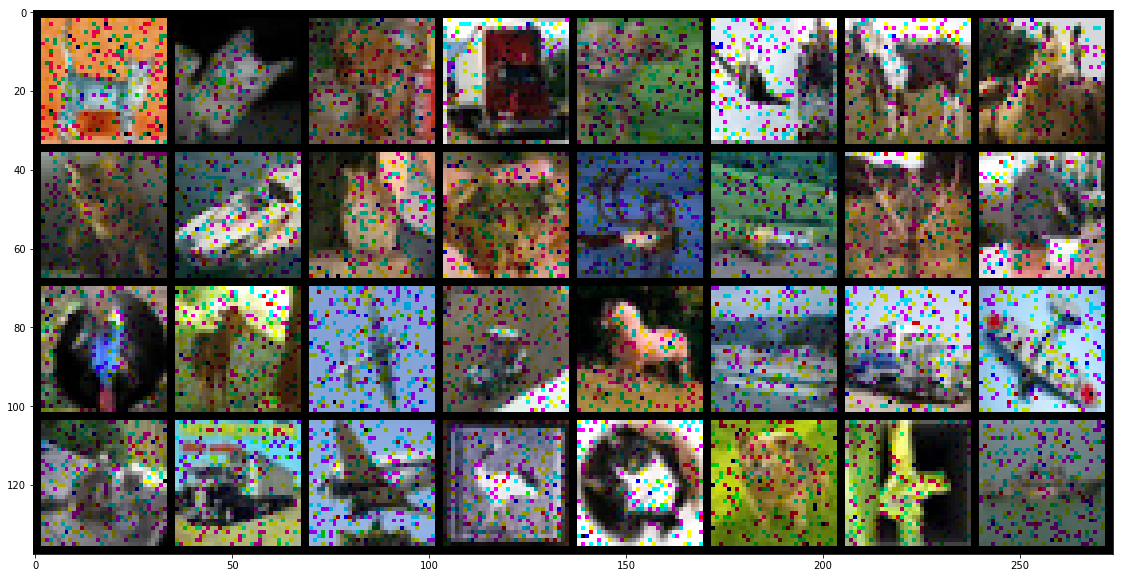

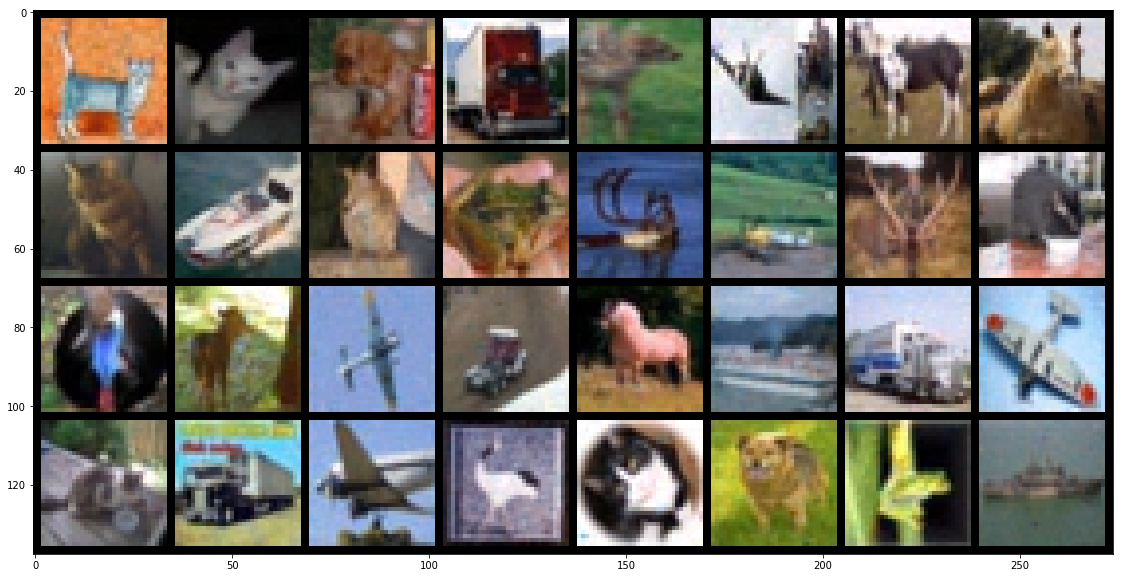

In [25]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

noise = torch.tensor(np.random.choice([0,1], p=[0.1,0.9], size=images.size()))
images = images * noise.float()

# print images
imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = convo_auto(images.cuda()).cpu()
# print images
imshow(torchvision.utils.make_grid(outputs).detach())

In [26]:
import zipfile

In [27]:
import os

In [54]:
os.listdir('../data/stanford-dogs-dataset/Images/n02111889-Samoyed')

['n02111889_4679.jpg',
 'n02111889_5965.jpg',
 'n02111889_5489.jpg',
 'n02111889_6750.jpg',
 'n02111889_899.jpg',
 'n02111889_2952.jpg',
 'n02111889_17626.jpg',
 'n02111889_6041.jpg',
 'n02111889_6343.jpg',
 'n02111889_4470.jpg',
 'n02111889_4408.jpg',
 'n02111889_1019.jpg',
 'n02111889_7042.jpg',
 'n02111889_12045.jpg',
 'n02111889_5463.jpg',
 'n02111889_1995.jpg',
 'n02111889_16414.jpg',
 'n02111889_6592.jpg',
 'n02111889_853.jpg',
 'n02111889_2361.jpg',
 'n02111889_1918.jpg',
 'n02111889_14746.jpg',
 'n02111889_16434.jpg',
 'n02111889_789.jpg',
 'n02111889_1772.jpg',
 'n02111889_1762.jpg',
 'n02111889_15038.jpg',
 'n02111889_2186.jpg',
 'n02111889_10206.jpg',
 'n02111889_15020.jpg',
 'n02111889_2667.jpg',
 'n02111889_16116.jpg',
 'n02111889_6811.jpg',
 'n02111889_3400.jpg',
 'n02111889_3345.jpg',
 'n02111889_1739.jpg',
 'n02111889_1984.jpg',
 'n02111889_2029.jpg',
 'n02111889_13737.jpg',
 'n02111889_2914.jpg',
 'n02111889_7491.jpg',
 'n02111889_10084.jpg',
 'n02111889_16334.jpg',
 '

In [53]:
from PIL import Image

In [63]:
p = transforms.Compose([transforms.Resize((200,200)),
                       transforms.ToTensor()])

<function Tensor.size>

In [84]:
train_dataset = torchvision.datasets.ImageFolder(
    root = '../data/stanford-dogs-dataset/Images/Train',
    transform = p
)

In [97]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset,range(0,100)),
                                          batch_size = 4,
                                          num_workers = 0,
                                          shuffle = True)
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset,range(100,707)),
                                          batch_size = 4,
                                          num_workers = 0,
                                          shuffle = True)

In [106]:
num_epochs = 10
for i in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = Variable(img)
        
        noise = torch.tensor(np.random.choice([0,1], p=[0.3,0.7], size=img.size()))
        img1 = img * noise.float()
        
        output = convo_auto(img1.cuda())
        loss = criterion(output, img.cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(i+1, num_epochs,loss.item()))

Epoch [1/10], Loss: 0.0005
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0011
Epoch [4/10], Loss: 0.0008
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0010
Epoch [7/10], Loss: 0.0006
Epoch [8/10], Loss: 0.0007
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


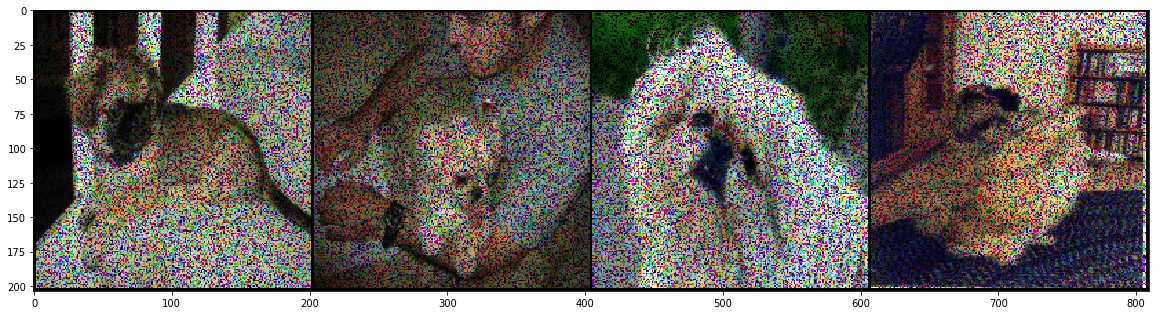

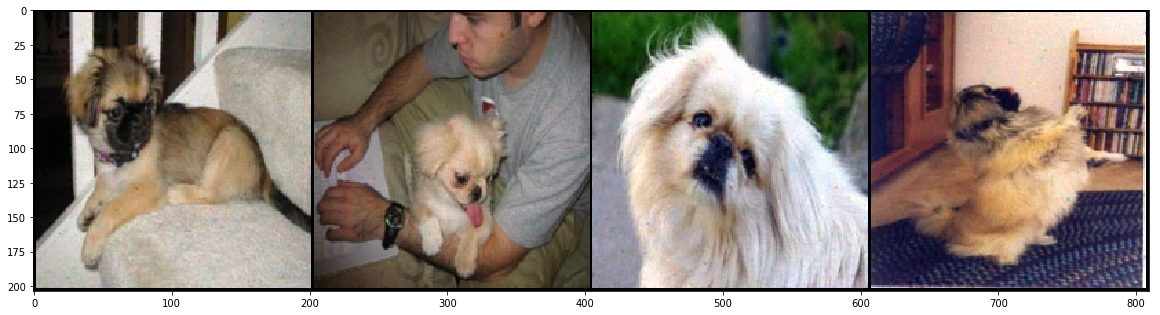

In [109]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

noise = torch.tensor(np.random.choice([0,1], p=[0.3,0.7], size=images.size()))
images = images * noise.float()

# print images
imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = convo_auto(images.cuda()).cpu()
# print images
imshow(torchvision.utils.make_grid(outputs).detach())